In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain

import skimage
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.util import crop, pad
from skimage.morphology import label
from skimage.color import rgb2gray, gray2rgb, rgb2lab, lab2rgb

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model, load_model,Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, UpSampling2D, RepeatVector, Reshape
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras import backend as K

**Loading Data**

In [2]:
#!pip install -q kaggle
#!mkdir ~/.kaggle
#!touch ~/.kaggle/kaggle.json
#api_token = {"username":"Your UserName","key":"Your key"}
#import json
#with open('/root/.kaggle/kaggle.json', 'w') as file:
  # json.dump(api_token, file)
#!chmod 600 ~/.kaggle/kaggle.json
#!kaggle datasets download -d thedownhill/art-images-drawings-painting-sculpture-engraving

In [3]:
# !wget --no-check-certificate -r 'https://drive.google.com/uc?export=download&id=1CKs7s_MZMuZFBXDchcL_AgmCxgPBTJXK' -O art-images-drawings-painting-sculpture-engraving.zip

In [4]:
# !unzip art-images-drawings-painting-sculpture-engraving.zip -d /content/drive/MyDrive/Dataset/art-images-drawings-painting-sculpture-engraving

In [5]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
TRAIN_PATH = '/content/drive/MyDrive/Dataset/art-images-drawings-painting-sculpture-engraving/dataset/dataset_updated/training_set/painting/'
train_ids = next(os.walk(TRAIN_PATH))[2]

In [6]:
missing_count = 0
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
  path = TRAIN_PATH + id_+ ''
  try:
    img = imread(path)  
  except:
    missing_count += 1
print("\n\nTotal missing: "+ str(missing_count))

100%|██████████| 2128/2128 [18:30<00:00,  1.92it/s]



Total missing: 86


In [7]:
X_train = np.zeros((len(train_ids)-missing_count, IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
missing_images = 0
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
  path = TRAIN_PATH + id_+ ''
  try:
    img = imread(path)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH),
    mode='constant', preserve_range=True)
    X_train[n-missing_images] = img
  except:
    missing_images += 1
X_train = X_train.astype('float32') / 255.

100%|██████████| 2128/2128 [00:35<00:00, 59.51it/s]


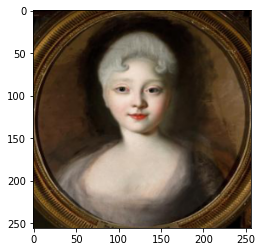

In [8]:
plt.imshow(X_train[5])

**Creating Training/Testing Datasets**

In [9]:
x_train, x_test = train_test_split(X_train,test_size=20)

**Preparing Training Dataset**

In [10]:
datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    horizontal_flip=True
)

In [11]:
def create_training_batches(dataset=X_train, batch_size = 20):
  # iteration for every image
  for batch in datagen.flow(dataset, batch_size=batch_size):
    # convert from rgb to grayscale
    X_batch = rgb2gray(batch)
    # convert rgb to Lab format
    lab_batch = rgb2lab(batch)
    # extract L component
    X_batch = lab_batch[:,:,:,0]
    # reshape
    X_batch = X_batch.reshape(X_batch.shape+(1,))
    # extract a and b features of the image
    Y_batch = lab_batch[:,:,:,1:] / 128
    yield X_batch, Y_batch

**Defining Model**

In [12]:
# the input for the encoder layer
inputs1 = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1,))

In [13]:
# encoder
# Using Conv2d to reduce the size of feature maps and image size
# convert image to 128x128
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(inputs1)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)

# convert image to 64x64
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

# convert image to 32x32
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same') (encoder_output)

# mid-level feature extractions
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

# decoder
# Adding colors to the grayscale image and upsizing it
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

# image size 64x64
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

# image size 128x128
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

model = Model(inputs=inputs1, outputs=decoder_output)

model.compile(loss='mse', optimizer='adam',metrics=['accuracy'])

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 256)       590080    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 512)       118016

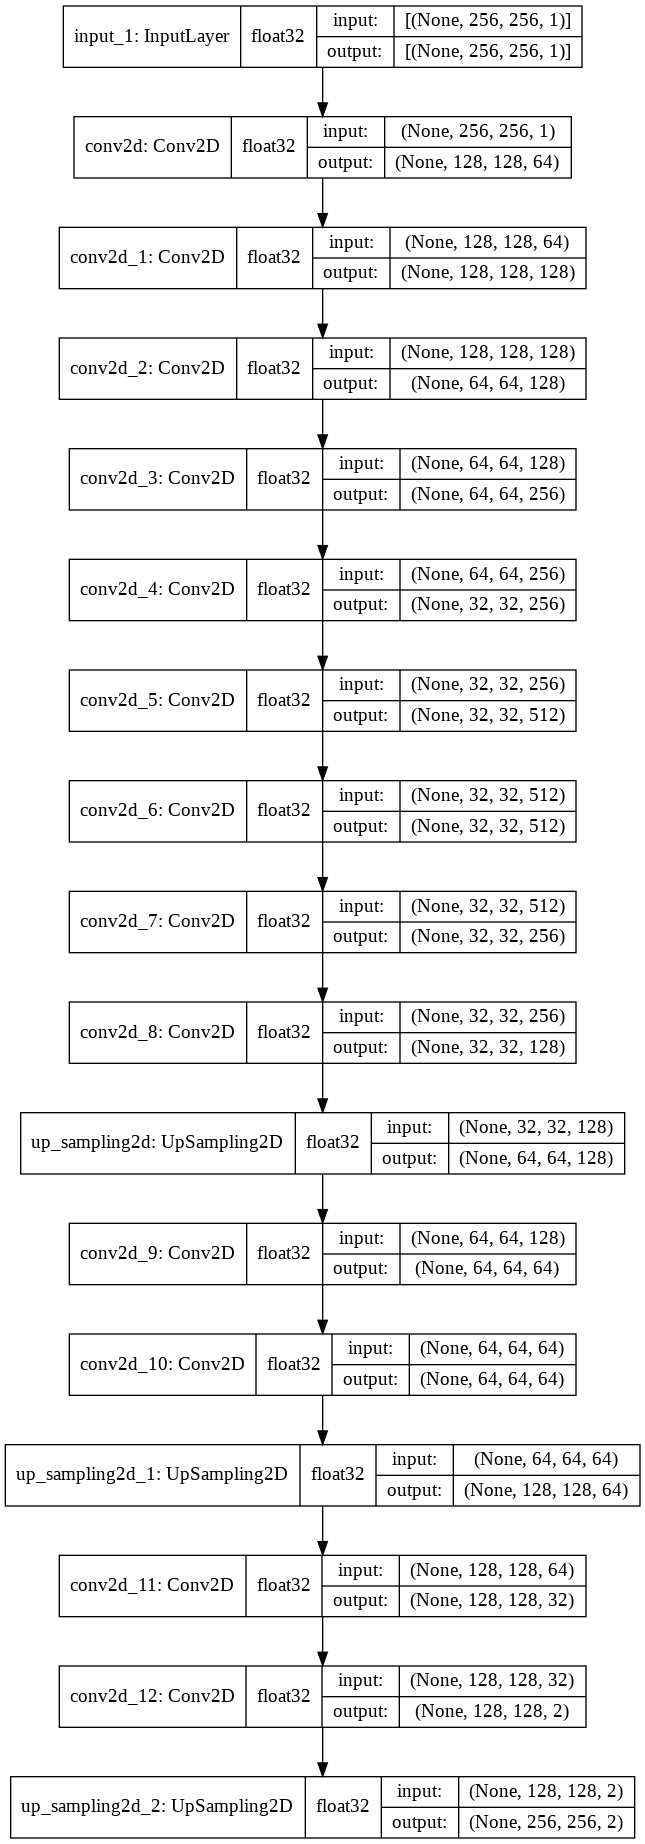

In [15]:
tf.keras.utils.plot_model(model, to_file='autoencoder_model.png',show_dtype=True,show_shapes=True)

**Model Training**

In [16]:
BATCH_SIZE = 20
model.fit(
    create_training_batches(X_train,BATCH_SIZE),
    epochs= 100,
    verbose=1,
    steps_per_epoch=X_train.shape[0]/BATCH_SIZE
)

Epoch 1/100
102/102 [==============================] - 66s 474ms/step - loss: 0.0142 - accuracy: 0.8461
Epoch 2/100
102/102 [==============================] - 48s 474ms/step - loss: 0.0052 - accuracy: 0.8706
Epoch 3/100
102/102 [==============================] - 49s 480ms/step - loss: 0.0048 - accuracy: 0.8703
Epoch 4/100
102/102 [==============================] - 49s 476ms/step - loss: 0.0047 - accuracy: 0.8702
Epoch 5/100
102/102 [==============================] - 49s 475ms/step - loss: 0.0046 - accuracy: 0.8703
Epoch 6/100
102/102 [==============================] - 48s 473ms/step - loss: 0.0045 - accuracy: 0.8697
Epoch 7/100
102/102 [==============================] - 49s 479ms/step - loss: 0.0045 - accuracy: 0.8700
Epoch 8/100
102/102 [==============================] - 49s 480ms/step - loss: 0.0045 - accuracy: 0.8701
Epoch 9/100
102/102 [==============================] - 48s 470ms/step - loss: 0.0044 - accuracy: 0.8682
Epoch 10/100
102/102 [==============================] - 48s 469m

**Testing**

In [17]:
test_image = rgb2lab(x_test)[:,:,:,0]
test_image = test_image.reshape(test_image.shape+(1,))
output = model.predict(test_image)
output = output * 128

# making the output image array
generated_images = np.zeros((len(output),256, 256, 3))
for i in range(len(output)):
  #iterating for the output
  cur = np.zeros((256, 256, 3))
  # dummy array
  cur[:,:,0] = test_image[i][:,:,0]
  #assigning the gray scale component
  cur[:,:,1:] = output[i]
  #assigning the a and b component
  #converting from lab to rgb format as plt only work for rgb mode
  generated_images[i] = lab2rgb(cur)

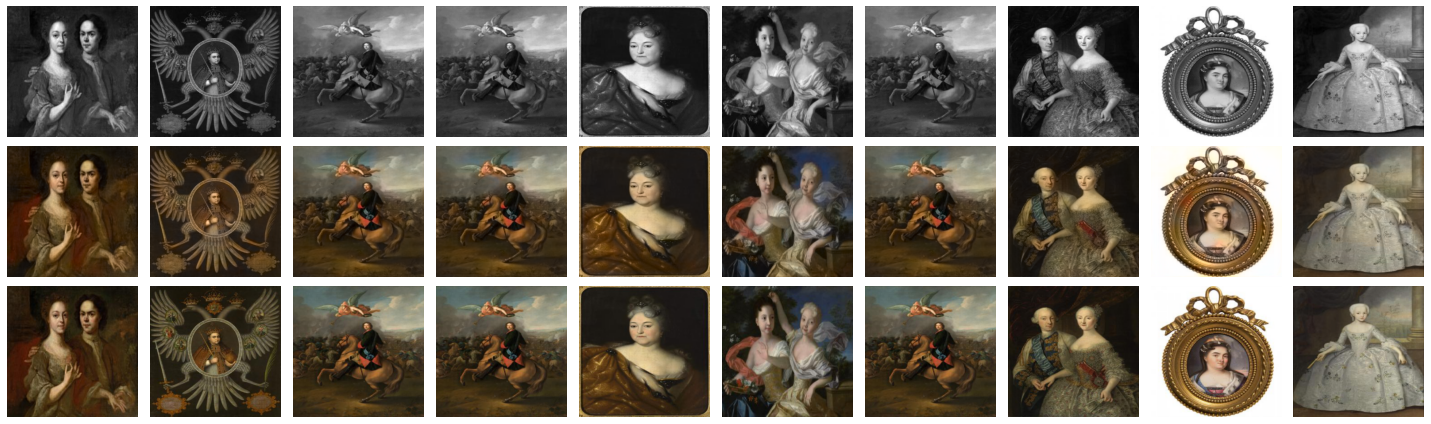

In [18]:
plt.figure(figsize=(20, 6))
for i in range(10):
  # grayscale
  plt.subplot(3, 10, i + 1)
  plt.imshow(rgb2gray(x_test)[i].reshape(256, 256))
  plt.gray()
  plt.axis('off')
  # recolorization
  plt.subplot(3, 10, i + 1 +10)
  plt.imshow(generated_images[i].reshape
  (256, 256,3))
  plt.axis('off')
  # original
  plt.subplot(3, 10, i + 1 + 20)
  plt.imshow(x_test[i].reshape(256, 256,3))
  plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
img = img.astype('float32') / 255.
test_image = rgb2lab(img)[:,:,0]
test_image = test_image.reshape((1,)+test_image.shape+(1,))
output = model.predict(test_image)
output = output * 128
plt.imshow(img)
plt.axis('off')